In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook()

##### Lab07 Mini Project: Classification

In this lab, we will be going over the Nearest Neighbors, a classification algorithm.

Relevant chapters from the textbook are:
* [Chapter 7](https://www.inferentialthinking.com/chapters/07/Visualization.html)
* [Chapter 8](https://www.inferentialthinking.com/chapters/08/Functions_and_Tables.html)
* [Chapter 17](https://www.inferentialthinking.com/chapters/17/Classification.html)

We are skipping over quite a bit of the textbook for now, but most of the material builds on what we have already seen.

In [1]:
import numpy as np
from datascience import *
#from NearestNeighbors import *

# These lines set up graphing capabilities.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
############# Ignore these Functions For Now ############
############# Just run this cell #############

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def make_grid(min_, max_, step):
    x_array = make_array()
    y_array = make_array()
    for x in np.arange(min_, max_, step):
        for y in np.arange(min_, max_, step):
            x_array = np.append(x_array, x)
            y_array = np.append(y_array, y)
    return x_array, y_array

def distance_nn(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance_nn(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def classify_table(training, points, k):
    """Classify a table of unlabled points using KNN"""
    def classify_p(p):
        return classify(training, p, k)

    classes = points.apply(classify_p)
    return points.with_column('Class', classes)

def draw_nearest_neighbor(table, point):
    with_distances = table_with_distances(table, point)
    distances_sorted = with_distances.sort('Distance', descending=False)

    t = distances_sorted.drop('Distance')

    x_closest = t.row(0).item(0)
    y_closest = t.row(0).item(1)

    table.scatter(table.labels[0], table.labels[1], group='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

# 0. What is the distance between two points?

### Data: weight and height

This table contains the hypothetical heights (in meters) and weights (in kilograms) of your teaching staff. 

_Note that in order to create our first visualization, we added a column of all zeros called "dummy"._

In [3]:
weight_height_table = Table().with_columns(
        "dummy", make_array(0,0,0,0,0),
        "name", make_array("Kate", "Alyssa", "Alexis", "Sean", "Yingrui"),
        "weight(kg)", make_array(40.5, 47.7, 53.3, 99.9, 60.4),
        "height(m)", make_array(1.74, 1.62, 1.7, 1.85, 1.53))

**Question 0.1. 1-D distance**  
Take a look at the heights, how do we calculate the distance between Yingrui and Alyssa's heights? Whose height is closest to Sean's?

_Note that in order to create this visualization, we can take advantage of our column of zeros that we called "dummy"._

In [4]:
weight_height_table.scatter('height(m)', 'dummy', group='name', s=92)

* How do we visualize the weight distribution?
* How do we calculate the distance between Yingrui and Alyssa's weight? 
* Whose weight is closest to Kate's? 

In [5]:
...

**Question 2. 2-D distance** 
Now we can look at both the heights and weights. Each of the staff is represented in a two-dimensional (2-D) space now. 

Plot the points with `height` on x-axis and `weight` on y-axis.

Now if we want to find out who is closest to Yingrui in terms of both weight and height. What do we do? 

In [6]:
...

We look at the length of the straight line between the two point!

This distance is called **Euclidean distance** and below is a 4-minute video on youtude introducing why we need Euclidean distance in Machine Learning.

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo("imD_XsEV-90")

## 1. Chronic Kidney Disease (CKD)
We are going to try to predict Chronic Kidney Diseases based on a number of health indicators. To do this, we are first going to upload the 'ckd' dataset.

This dataset can be found here: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease.

In [8]:
ckd_full = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd_full

We see that this table contains a number of columns, each corresponding to a health indicator or **feature**. Each row in the table is a different patient. The `Class` column tells us whether or not the patient has Chronic Kidney Disease. A `Class` label of 1 means the patient has the disease and 0 means they do not.

### 1.1 Clean the Data

We are only going to look at the relationship between Hemoglobin and glucose levels to having CKD. To do this, we are going to make a new table that has only `Hemoglobin`, `Glucose`, and `Class` columns. Also, we are going to use what are know as *standard units*. Without going into too much detail, standard units makes it so that the difference in scale  of the different features will not matter.

The standard unit literally measures the number of standard deviations away from the norm. This means that the average value for both `Hemoglobin` and `Glucose` will be zero. A value of one in either feautre will correspond to being one standard deviation away from the mean. 

We wrote the function to convert the column values into standard units, so all you need to do now is assemble the table: include the 'Hemoglobin' and 'Glucose' vectors in standard units, and include the column 'Class' from the original table.

<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [9]:
hemoglobin = standard_units(ckd_full.column('Hemoglobin'))
glucose = standard_units(ckd_full.column('Glucose'))

ckd = ...

In [ ]:
grader.check("q1_1")

<!-- BEGIN QUESTION -->

### 1.2 Visualizing the Data
Now we are going to visualize this data. Let's make a scatter plot with the `Hemoglobin` on the x-axis, `Glucose` on the y-axis and the have the color correspond to the value of `Class`. To do this, we use the normal call to `scatter`, and add the optional parameter `group='Class'`.
<!--
BEGIN QUESTION
name: q1_2
manual: true
-->

In [13]:
...
ckd.scatter(..., group='Class')

<!-- END QUESTION -->



### 1.3 Interpreting The Plot
From this scatter plot, would you be able to determine if someone has CKD based only on their Hemoglobin and Glucose levels? What values for each would make you be more or less confident in your prediction? 


_Type your answer here, replacing this text._

# 2. Nearest Neighbor Search

We are going to use a simple, yet effective method for predicting CKD called *Nearest Neighbor Search*. From the scatter plot we made, we should see that patients that had similar hemoglobin and glucose levels were likely to have the same diagnosis. This suggests that we can infer the label of a new data point by looking at the labels of data points close by. In fact, we can get a pretty good estimate just by looking at the label of the point _closest_ to our new data point.


## 2.1 Implementaion
We are going to implement our Nearest Neighbor classifier by choosing the label of the point closest to our new point. 

Note that in this section, we are going to build on code that we write in subsequent sections. So, it is very important that you go through this assignment in order so that each component works correctly before moving on to downstream components.


### 2.1.1. Distance Between 2 Points

In order to find the closest point to our new data point, we first need to be able to measure the distance between two points. Here's a quick explanation about how to find the distance between two points.

Suppose we want to find the distance between the points: $P_1=(1,5)$ and $P_2=(4, 1)$

Before finding the distance between the two points, let's visualize the difference between the x coordinates of the two points and the difference between the y coordinates of the two points. We wrote the code for you to visualize the resulting right triangle.

In [14]:
plt.figure(figsize=(4.5,4.5))
plt.plot(make_array( 1, 4), make_array( 5, 1), color='k', lw=2);
plt.plot(make_array( 1, 1, 4), make_array( 5, 1, 1), '--',color='k', lw=1);

plt.scatter(make_array( 1, 4), make_array( 5, 1), color='r')
plt.text(2.5, 0.5, "a")
plt.text(0.5, 2.5, 'b')
plt.text(2.5, 3.5, 'c')
plt.xlim(0, 6)
plt.ylim(0, 6);

The difference between the x coordinates, represented by the line `a`, and the difference in the y coordinates, represented by the line `b` is something we can solve for. We know that $a = x_2 - x_1$ and $b = y_2 -y_1$. Now we still have to find the length of `c`. 

Notice that the triangle consisting of the lines `a, b, c` make a right triangle, where `c` is the hypotenuse. Hopefully, we remember that the lenthgs of the sides of a right triangle are determined by the **Pythagorean Theorem**:

$$ c^2 = a^2 + b^2 $$

Now to solve for `c`, we simply take the square root of both sides to get:
$$ c = \sqrt{a^2 + b^2} $$

<!--
BEGIN QUESTION
name: q2_1_0
points: 1
manual: false
-->
**q2.1.0.** Find the distance between $P_1=(1,5)$ and $P_2=(4, 1)$ by finding the distance between the x-coordinates `a`, the difference between the y-coordinates `b` and then using the **Pythagorean Theorem** to find `c`.

In [15]:
a=...
b=...
c=...

In [ ]:
grader.check("q2_1_0")

<!--
BEGIN QUESTION
name: q2_1_1
points: 1
manual: false
-->
**q2.1.1.** Implement a function called `distance` that returns the distance between two *arbitrary* points, each stored **as an array**.

Recall that the distance between two *arbitray* points $P_1=(x_1, y_1)$, $P_2 = (x_2, y_2)$ in two dimensions is:
$$Dist(P_1, P_2)=\sqrt{(x_1-x_2)^2+ (y_1-y_2)^2}$$

*hint:* you can use the `np.sqrt` function.

In [19]:
def distance(p1, p2):
    # First split each point into their individual dimension. 
    x_1, y_1 = p1.item(0), p1.item(1)
    x_2, y_2 = p2.item(0), p2.item(1)

In [ ]:
grader.check("q2_1_1")

### 2.1.2 Getting Distance To All Points

For the rest of the section, suppose we are trying to classify a point **(0, 1)**. In order to find the closest point to (0,1), we need to measure the distance between the (0,1) and **_all points_** in the dataset. 

#### q2.1.2a: Create a table with only the features
In order to do this, let's create a new table that just has the features of the CKD table, without the `Class` column. (Use the `drop` method)

<!--
BEGIN QUESTION
name: q2_1_2a
manual: false
-->

In [23]:
ckd_features = ...
ckd_features

In [ ]:
grader.check("q2_1_2a")

#### 2.1.2b: Compute the distances to a new point

Now we want make a new array that contains the distance from each original point to our new data point. We can do this with the `apply` function. 

We have to be careful, because functions we pass into `apply` can only take one argument, the row. However our `distance` function takes in 2 arguments; each argument is a different point. 

Because we need distances from all points in the table to (0,1), every time we call `distance` one of the points we pass in as parameters will be (0,1). So, we can write a new function that takes the distance between (0,1) and a point from our table that is passed in as a parameter.

**q.1.2b** Implement a function that takes the distance between an arbitrary point and the point (0,1).
<!--
BEGIN QUESTION
name: q2_1_2b
manual: false
-->

In [27]:
def distance_from_0_1(row):
    return ...

In [ ]:
grader.check("q2_1_2b")

#### 2.1.2c Compute the distances from a new point to all points in the dataset
<!--
BEGIN QUESTION
name: q2_1_2c
manual: false
-->

**q.1.2b** Now make a new table called `ckd_distance` that is equivalent to `ckd` with the distance to the point (1,0) added as a column labeled "Distance". To do this, you will need to apply `distance_from_1_0` to the `ckd_features` table.

In [30]:

distances_to_1_0 = ...
ckd_distances = ...
ckd_distances

In [ ]:
grader.check("q2_1_2c")

#### 2.1.2d Find the label of the closest neighbor

**q2.1.2d** Now for the last step, find the label of the point in `ckd` with the smallest distance to (0,1).

<!--
BEGIN QUESTION
name: q2_1_2d
manual: false
-->

In [33]:
label = ...
label

In [ ]:
grader.check("q2_1_2d")

---

# 4 Lobsters

Let's see how we can do the same classification on a different dataset.

`lobster.csv` contains a fictitious dataset of various organisms of a recently discovered lobster that lives exclusively in the marine refuge surrounding Coal Oil Point. The data, for what is now referred to as the Jaffe Lobster, was collected by one of the TAs for this course over a laborious weekend. Upload the data into a Table and view it's contents.

In [36]:
lobster = Table.read_table('lobster.csv')
lobster

<!-- BEGIN QUESTION -->

The table has 3 columns, `Claw Width`, `Tail Length`, and `Class`. During lobster fishing season it is illegal to catch female lobsters, which have a class label of 0, to sustain the lobster population. As scientists/fishermen, we want to be able to determine the sex of a lobster based off of its claw width and tail length. 

First, let's see if this is possible by plotting the data as we did with Chronic Kidney Disease table.

**q4.1.** Make a scatter plot of the lobster table and color each point by the 'Class' column using the optional parameter `group='Class'`.
<!--
BEGIN QUESTION
name: q4_1
manual: true
-->

In [37]:
lobster.scatter(..., group='Class')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**q4.2.** The regions for male/female lobster are not as clear cut as the CKD table. However, it seems the features can be used to determine the sex of the lobster. How would you describe the relationship between claw width, tail length, and the sex of the lobster?

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



**A Problem with Nearest Neighbor Search**
The regions identifying female and male lobsters are not cleanly separated. Let's investigate what is causing the issue by looking at a single point: (17,5). 

We arguably want to see the region of male class '1' lobsters be a solid diagonal stripe. It would also be nice if the regions of female class '0' lobsters made solid triangles on either side of the stripe. However, because some male lobsters cross into the region of female lobsters, and because our classified data points are relatively sparse, some points well within the expected region of the female lobsters have as their nearest neighbor a male lobster.

We can see this occured witht the point (17, 5). You may notice, that the next several closest neighbors of that point all have the female. This suggests that we can generate a better decision boundary, and get better labels, by looking at the labels of a few closest neighbors instead of just one. We will discuss this strategy more in depth next week.

<!-- BEGIN QUESTION -->

# 5 Training and Testing

We would like to evaluate the effectiveness of our Nearest Neighbors Classifer. To do this we will compare the classifier's predictions of a set of points against their actual labels. 

We have to be careful about how we select the data to evaluate our algorithm. Suppose we classify a point in `lobster` by finding it's closest neighbor in `lobster`. That point's closest neighbor is always going to be itself, and selecting a point's own class will always be correct. 

**q5.0** Why is any point's closest neighbor in `lobster` is always going to be that point itself?
<!--
BEGIN QUESTION
name: q5_0
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

We want to evaluate how well Nearest Neighbors classified data where the label is unkown. To make evaluation, we will simulate having unlabeled data by splitting the `lobster` dataset into a *training* set and a *testing* set. 

The Nearest Neighbors algorithm will classify data using just the *training* set. We will then use this algorithm to classify all of the points in the *testing* set and compare the results agains the actual classes of the testing set.

**q5.1.** Split the data into training and testing sets by making the training set equal to the first 160 rows of `lobster` and making the testing set equal to the the last 40 rows of `lobster`. 

*Note that this a reasonable method for splitting our data because the data in `lobster` is already sorted. What problems could arise if the data was not sorted before splitting the data?*
<!--
BEGIN QUESTION
name: q5
manual: false
-->

In [38]:
training = ...
testing = ...

In [ ]:
grader.check("q5")

## 5.1 Visualizing the Training Boundary
Before evaluating on the testing set, let's visulaize the decision boundary created by Nearest Neighbors that looks at points that are only in the training set. 

The plot below, which we have generated for you to save time, displays the scatter plot of the just the training data and the decision boundary generated by finding the nearest neighbor of points just in the trianing set.

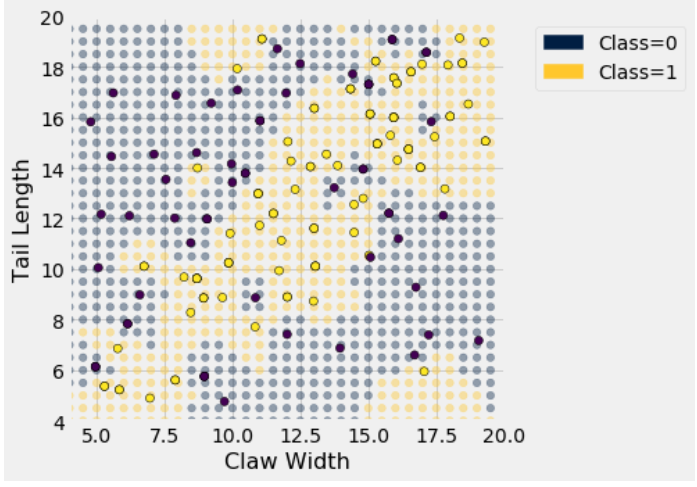

Now let's plot the same decision boundary. But this time, let's overlay it with the points in the testing set. 

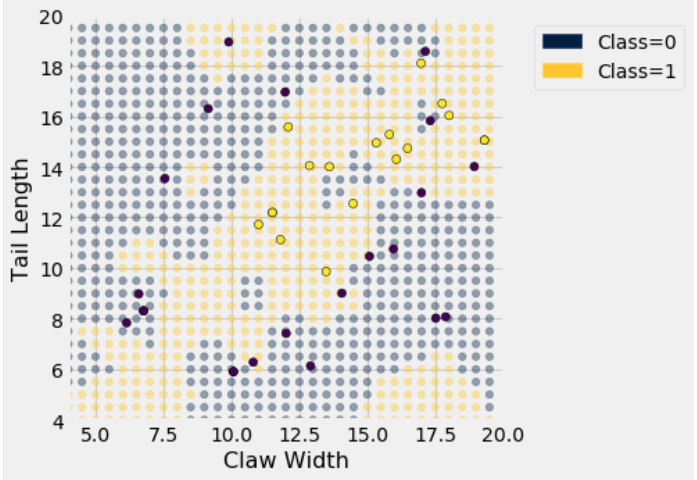

Most of the points are classified correctly. However, a few points, particularly blue points, exist in a region whose nearest neighbor in the trianing set is yellow. These points would be classified incorrectly. 

Next week, we'll get to look at evaluating the accuracy of our classifier and modifying the algorithm.

Congratulations, you are finished with this lab!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export("lab07.ipynb")